In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt

In [9]:


class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Getting the list of folders
        self.samples = sorted(os.listdir(root_dir))

        # Creating a dictionary for the supervised learning
        self.class_to_label = {}
        label_counter = 0

        #assigning labels
        for sample_name in self.samples:
            if sample_name.startswith("Sample") and label_counter <= 10:
                label = label_counter
            elif sample_name.startswith("Sample") and 10 < label_counter <= 36:
                label = chr(ord("a") + label_counter - 10)
            elif sample_name.startswith("Sample") and 36 < label_counter <= 62:
                label = chr(ord("A") + label_counter - 36)

            self.class_to_label[sample_name] = label
            label_counter += 1

        # Initialize lists to store file paths and labels
        self.file_paths = []
        self.labels = []

        # Populate file_paths and labels based on the folder structure
        for sample_name in self.samples:
            sample_path = os.path.join(root_dir, sample_name)
            label = self.class_to_label[sample_name]
            for filename in os.listdir(sample_path):
                file_path = os.path.join(sample_path, filename)
                self.file_paths.append(file_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]

        return image, label




In [10]:
root_folder = "datast"
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor()])

custom_dataset = CustomDataset(root_folder, transform=transform)

# chcking
sample_image, sample_label = custom_dataset[0]

# loader for traning
batch_size = 32
data_loader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

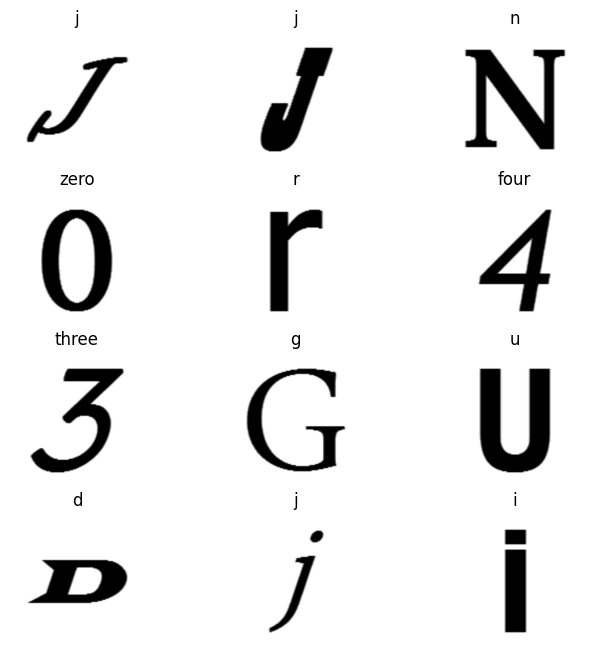

In [15]:
labels_map = {
    0:'zero',										
    1:'one',										
    2:'two',									
    3:'three',										
    4:'four',										
    5:'five',									
    6:'six',										
    7:'seven',										
    8:'eight',										
    9:'nine',
    'a': 'a',
    'b': 'b',
    'c': 'c',
    'd': 'd',
    'e': 'e',
    'f': 'f',
    'g': 'g',
    'h': 'h',
    'i': 'i',
    'j': 'j',
    'k': 'k',
    'l': 'l',
    'm': 'm',
    'n': 'n',
    'o': 'o',
    'p': 'p',
    'q': 'q',
    'r': 'r',
    's': 's',
    't': 't',
    'u': 'u',
    'v': 'v',
    'w': 'w',
    'x': 'x',
    'y': 'y',
    'z': 'z',
    'A': 'a',
    'B': 'b',
    'C': 'c',
    'D': 'd',
    'E': 'e',
    'F': 'f',
    'G': 'g',
    'H': 'h',
    'I': 'i',
    'J': 'j',
    'K': 'k',
    'L': 'l',
    'M': 'm',
    'N': 'n',
    'O': 'o',
    'P': 'p',
    'Q': 'q',
    'R': 'r',
    'S': 's',
    'T': 't',
    'U': 'u',
    'V': 'v',
    'W': 'w',
    'X': 'x',
    'Y': 'y',
    'Z': 'z',

}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(custom_dataset), size=(1,)).item()
    img, label = custom_dataset[sample_idx]
    
    img = img.permute(1, 2, 0)
    
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img)
    
plt.show()